##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [150]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [151]:
orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [152]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [153]:
df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [154]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [155]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


**Summary:**

X and Y are the coordinates of the crime

Area_Command is the area of the crime

NIBRSOffenseCode is the type of crime

DayOfWeek is the day of the week the crime occured

Time is the time of day the crime occured

VictimCount is the number of victims of the crime


---

X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time are the input columns VictimCount is the target columns

---
I have scale the data using MinMaxScaler which will transform the data in range of 0 to 1. This will help to improve the model performance.


In [156]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


In [157]:
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [158]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch
import pandas as pd
import numpy as np

# Define input and target variables
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
y = df['VictimCount']

#Scale the input data using MinMaxScaler in range of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

# Split the data into training and testing sets using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

batch_size = 8

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Counter to keep track of the number of batches
batch_count = 0

for inputs, targets in train_loader:
    batch_count += 1
    print(f"Batch {batch_count}:")
    print("Input shape:", inputs.shape)
    print("Output shape:", targets.shape)

print("Total batches:", batch_count)

Batch 1:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 2:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 3:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 4:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 5:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 6:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 7:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 8:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 9:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 10:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 11:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 12:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 13:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
Batch 14:
Input shape: torch.Size([8, 6])
Output shape: torch.Size([8])
B

## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

**Summary:**

The size for the predicted output should be 1. As, in regression model we need to predict a continuous value.

I have choose a neural network architecture which consists of 6 layers, including an input layer with 6 units and multiple hidden layers. These hidden layers contsit of both Tanh and ReLU activation functions to capture complex patterns and non-linear relationships in the data. The depth of the network enables it to learn hierarchical representations, with each layer extracting different features. The specific architecture and hyperparameters should be fine-tuned through experimentation to optimize model performance for the given dataset and task.

After training the model with different model, this was the architecture which has a more better and accurate result. I have train the model with different netword like 3,4,5,6,7,8 hidden layers and different activation function for each hidden layers, but only the model with 6 layers was having a better accuracy.

In [159]:
import torch.nn as nn
import torch.optim as optim
# Define the model
model = nn.Sequential(
    nn.Linear(6, 256),
    nn.Tanh(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.Tanh(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

# loss function - MSE and Optimizer - Adam
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# number of epochs
n_epochs = 100
batch_start = torch.arange(0, len(train_loader), batch_size)

# store the best model
best_mse = np.inf   # init to infinity
best_weights = None

test_history = []

for epoch in range(n_epochs):
    model.train()
    mse = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute the loss
        loss = loss_fn(outputs, targets)
        # Backpropagation
        loss.backward()
        # Optimize
        optimizer.step()
        # Update training MSE
        mse += ((outputs - targets) ** 2).mean().item()

    # Calculate the average training MSE for this epoch
    avg_mse = mse / len(train_loader)

    # Check if this model is the best so far
    if avg_mse < best_mse:
        best_mse = avg_mse

    # Evaluate the model on the test dataset
    model.eval()
    total_test_loss = 0.0

    for test_inputs, test_targets in test_loader:
        test_outputs = model(test_inputs)
        total_test_loss += ((test_outputs - test_targets) ** 2).mean().item()

    avg_test_mse = total_test_loss / len(test_loader)

    test_history.append(avg_test_mse)

    print(f'Epoch [{epoch + 1}/{n_epochs}], Training MSE: {avg_mse:.4f}, Test MSE: {avg_test_mse:.4f}')


Epoch [1/100], Training MSE: 1.6252, Test MSE: 1.3454
Epoch [2/100], Training MSE: 1.5318, Test MSE: 1.2438


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [3/100], Training MSE: 1.4117, Test MSE: 1.1192
Epoch [4/100], Training MSE: 1.2570, Test MSE: 0.9827
Epoch [5/100], Training MSE: 1.1205, Test MSE: 0.8911
Epoch [6/100], Training MSE: 1.0548, Test MSE: 0.8470
Epoch [7/100], Training MSE: 0.9980, Test MSE: 0.8344
Epoch [8/100], Training MSE: 0.9922, Test MSE: 0.8340
Epoch [9/100], Training MSE: 0.9906, Test MSE: 0.8358
Epoch [10/100], Training MSE: 0.9880, Test MSE: 0.8344
Epoch [11/100], Training MSE: 0.9801, Test MSE: 0.8368
Epoch [12/100], Training MSE: 0.9877, Test MSE: 0.8369
Epoch [13/100], Training MSE: 0.9801, Test MSE: 0.8377
Epoch [14/100], Training MSE: 0.9947, Test MSE: 0.8354
Epoch [15/100], Training MSE: 0.9776, Test MSE: 0.8377
Epoch [16/100], Training MSE: 0.9871, Test MSE: 0.8384
Epoch [17/100], Training MSE: 0.9788, Test MSE: 0.8377
Epoch [18/100], Training MSE: 0.9955, Test MSE: 0.8368
Epoch [19/100], Training MSE: 0.9781, Test MSE: 0.8384
Epoch [20/100], Training MSE: 0.9821, Test MSE: 0.8363
Epoch [21/100], T

In [160]:
average_loss = sum(test_history) / len(test_history)
print(f'Average Loss: {average_loss:.4f}')

Average Loss: 0.8509


## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

**Summary:**

To find the number of classes of output data we can count a unique values from output data using numpy library.

A network architecture of classification use 4 layer and different activation function like ReLU and Softmax. Whereas the network of regression consist of only 6 layer and only 2 tyes of activation function. Also the no. of units or neuron are different in both the architecture.

Cross Entrophy is used instead of MSE as a loss function for the classification model.

SGD optimizer is used in classification model istead of Adam.

After trying different varaition with different network design the best accuracy I could get was 52.43%.

In [161]:
class ClassificationModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ClassificationModel, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
        )
        self.output = nn.Sequential(
            nn.Linear(32, output_size),  # Output size is the number of classes
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.hidden(x)
        x = self.output(x)
        return x

input_size = 6
# Number of classes in your classification task
output_size = len(np.unique(y))

model = ClassificationModel(input_size, output_size)

# Define the loss function and optimizer used Cross-Entropy loss for multi-class
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

n_epochs = 100

best_accuracy = 0.0

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == targets).sum().item()
        total_samples += len(targets)

    accuracy = correct_predictions / total_samples
    avg_loss = running_loss / len(train_loader)

    print(f'Epoch [{epoch + 1}/{n_epochs}] - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
print("Best Accuracy: {:.2f}%".format(best_accuracy * 100))


Epoch [1/100] - Loss: 1.9468 - Accuracy: 0.2767
Epoch [2/100] - Loss: 1.9463 - Accuracy: 0.2961
Epoch [3/100] - Loss: 1.9456 - Accuracy: 0.3107
Epoch [4/100] - Loss: 1.9450 - Accuracy: 0.3204
Epoch [5/100] - Loss: 1.9444 - Accuracy: 0.3350
Epoch [6/100] - Loss: 1.9438 - Accuracy: 0.3398
Epoch [7/100] - Loss: 1.9433 - Accuracy: 0.3447
Epoch [8/100] - Loss: 1.9426 - Accuracy: 0.3447
Epoch [9/100] - Loss: 1.9419 - Accuracy: 0.3544
Epoch [10/100] - Loss: 1.9413 - Accuracy: 0.3544
Epoch [11/100] - Loss: 1.9407 - Accuracy: 0.3544
Epoch [12/100] - Loss: 1.9401 - Accuracy: 0.3544
Epoch [13/100] - Loss: 1.9395 - Accuracy: 0.3592
Epoch [14/100] - Loss: 1.9390 - Accuracy: 0.3592
Epoch [15/100] - Loss: 1.9382 - Accuracy: 0.3592
Epoch [16/100] - Loss: 1.9376 - Accuracy: 0.3592
Epoch [17/100] - Loss: 1.9369 - Accuracy: 0.3592
Epoch [18/100] - Loss: 1.9363 - Accuracy: 0.3592
Epoch [19/100] - Loss: 1.9356 - Accuracy: 0.3592
Epoch [20/100] - Loss: 1.9349 - Accuracy: 0.3592
Epoch [21/100] - Loss: 1.9344

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

**Summary:**

Task 3 and 4, I have trained two different machine learning model, one is Regression and other is Classification. Both the models are trained using different neural netork architecture, loss function and optimizer.

In task 3, we need to predict the victim count using the input data. However, In task 4 we need to classify the number of crime victims in 7 categories.

Results: Classification model worked more better than the regression model  becasue in classification we care classifying the categories in multiple groups. This helps in understanding the input data and output data.

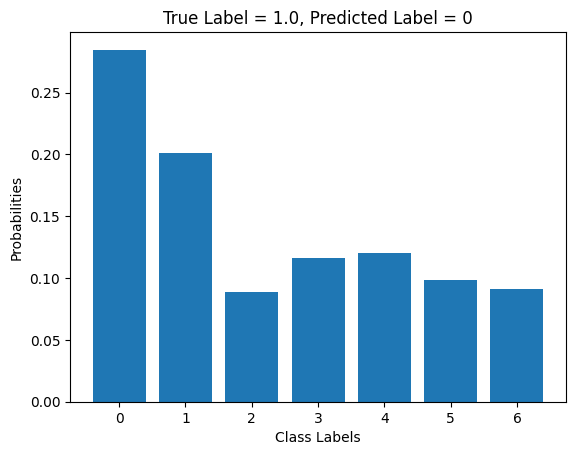

In [162]:
import matplotlib.pyplot as plt

# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)

# Find the first misclassified sample
misclassified_index = None
for i in range(len(y_test_tensor)):
    predicted_label = torch.argmax(outputs[i])
    if predicted_label != y_test_tensor[i]:
        misclassified_index = i
        break

if misclassified_index is not None:
    misclassified_output = outputs[misclassified_index]
    true_label = y_test_tensor[misclassified_index].item()

    # Get the class labels and probabilities
    class_labels = list(range(len(misclassified_output)))
    class_probabilities = misclassified_output.tolist()

    # Create a bar plot to visualize the model's output for the misclassified sample
    plt.bar(class_labels, class_probabilities)
    plt.xticks(class_labels)
    plt.title(f"True Label = {true_label}, Predicted Label = {predicted_label.item()}")
    plt.xlabel("Class Labels")
    plt.ylabel("Probabilities")
    plt.show()
else:
    print("No misclassified samples found in the test dataset.")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


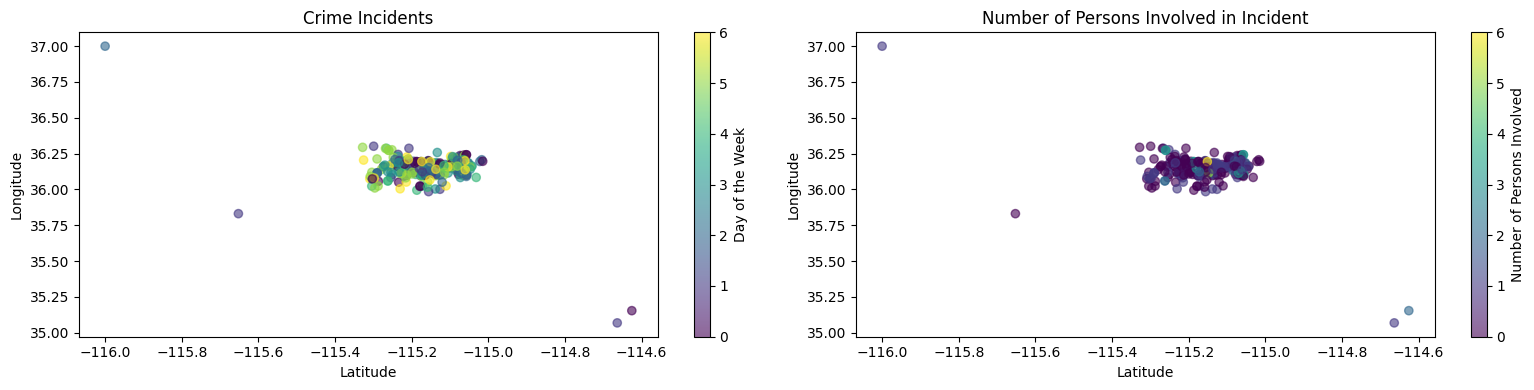

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

scatter1 = ax1.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', alpha=0.6)
ax1.set_title('Crime Incidents')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')
plt.colorbar(scatter1, label='Day of the Week', cmap='cool', ax=ax1)

scatter2 = ax2.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', alpha=0.6)
ax2.set_title('Number of Persons Involved in Incident')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')
plt.colorbar(scatter2, label='Number of Persons Involved', cmap='cool', ax=ax2)

plt.tight_layout()

plt.show()

In [164]:
crime_counts_by_day = df['DayOfWeek'].value_counts().reset_index()
crime_counts_by_day.columns = ['DayOfWeek', 'CrimeCount']
sorted_crime_counts = crime_counts_by_day.sort_values(by='CrimeCount', ascending=False)
print(sorted_crime_counts)

   DayOfWeek  CrimeCount
0          4          51
1          3          44
2          5          43
3          0          40
4          1          37
5          2          32
6          6          28
